In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
def transform_action_values(n_actions, min_action=-2.0, max_action=2.0):
    linear_actions = np.linspace(-1, 1, n_actions)
    non_linear_actions = np.sign(linear_actions) * (linear_actions ** 2)
    scaled_actions = min_action + (non_linear_actions + 1) * (max_action - min_action) / 2
    return np.append(scaled_actions, [0]*(int(len(scaled_actions)*0.2)))

In [10]:
# Define the Replay Buffer class
class PriorityReplayBuffer:
    def __init__(self, buffer_limit, alpha):
        self.buffer = []
        self.priorities = []
        self.buffer_limit = buffer_limit
        self.alpha = alpha
        self.pos = 0
        self.priorities_sum = 0

    def put(self, transition, priority):
        if len(self.buffer) < self.buffer_limit:
            self.buffer.append(transition)
            self.priorities.append(priority)
        else:
            self.buffer[self.pos] = transition
            self.priorities_sum -= self.priorities[self.pos]
            self.priorities[self.pos] = priority
        self.priorities_sum += priority
        self.pos = (self.pos + 1) % self.buffer_limit

    def sample(self, n, beta):
        scaled_priorities = [p ** self.alpha for p in self.priorities]
        sample_probs = [p / self.priorities_sum for p in scaled_priorities]
        sampled_indices = np.random.choice(len(self.buffer), n, p=sample_probs)
        
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in sampled_indices])
        weights = [(1 / (len(self.buffer) * sample_probs[i])) ** beta for i in sampled_indices]

        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones), np.array(weights), sampled_indices

    def update_priorities(self, indices, new_priorities):
        for idx, p in zip(indices, new_priorities):
            self.priorities_sum -= self.priorities[idx]
            self.priorities[idx] = p
            self.priorities_sum += p

    def size(self):
        return len(self.buffer)


In [6]:
# Define the Q-Network class
class DQNNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, state):
        x = F.leaky_relu(self.fc1(state))
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_values = transform_action_values(action_size)
        self.action_size = len(self.action_values)
        self.memory = PriorityReplayBuffer(buffer_limit=1000000, alpha=0.6)
        self.batch_size = 256
        self.tau = 0.01
        self.gamma = 0.9
        self.epsilon = 1
        self.epsilon_decay = 0.9999
        self.epsilon_min = 0.0001
        self.beta_start = 0.4
        self.beta_end = 1.0
        self.beta_increment_per_sampling = 0.001
        self.beta = self.beta_start
        self.learning_rate = 0.005
        self.model = DQNNetwork(state_size, self.action_size).to(device)
        self.target_model = DQNNetwork(state_size, self.action_size).to(device)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def select_action(self, state_tensor):
        if np.random.rand() > self.epsilon:
            action_index = torch.argmax(self.model(state_tensor)).item()
            action = self.action_values[action_index]
        else:
            action_index = np.random.randint(len(self.action_values))
            action = self.action_values[action_index]
        return action, action_index

    def store_experience(self, state, action, reward, next_state, done):
        max_priority = max(self.memory.priorities, default=1.0)
        # Store the experience with its priority
        self.memory.put((state, action, reward, next_state, done), max_priority)

    def train_agent(self):
        if self.memory.size() < self.batch_size:
            return

        self.beta = min(self.beta + self.beta_increment_per_sampling, self.beta_end)
        s_batch, a_batch, r_batch, s_prime_batch, done_batch, weights, indices = self.memory.sample(self.batch_size, self.beta)

        # Convert numpy arrays to PyTorch tensors and move them to the device
        s_batch = torch.tensor(s_batch, dtype=torch.float32).to(device)
        # Ensure a_batch is of dtype torch.int64 for use as an index
        a_batch = torch.tensor(a_batch, dtype=torch.int64).to(device).unsqueeze(1)
        r_batch = torch.tensor(r_batch, dtype=torch.float32).to(device).unsqueeze(1)
        s_prime_batch = torch.tensor(s_prime_batch, dtype=torch.float32).to(device)
        done_batch = torch.tensor(done_batch, dtype=torch.float32).to(device).unsqueeze(1)
        weights = torch.tensor(weights, dtype=torch.float32).to(device)

        # Calculate Q values and expected Q values
        q_values = self.model(s_batch).gather(1, a_batch)
        next_q_values = self.target_model(s_prime_batch).detach().max(1)[0].unsqueeze(1)
        expected_q_values = r_batch + self.gamma * next_q_values * (1 - done_batch)

        # Compute loss
        loss = F.smooth_l1_loss(q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Epsilon decay
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        # Soft update the target network
        for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)


Epoch 1/300, Score: -1534.2273685779833, Epsilion: 1
Epoch 2/300, Score: -1170.2222823248055, Epsilion: 0.9856039041216536
Epoch 3/300, Score: -1609.807443145789, Epsilion: 0.9660866730744385
Epoch 4/300, Score: -1643.4562982779173, Epsilion: 0.9469559282273666
Epoch 5/300, Score: -958.1017252974741, Epsilion: 0.9282040162620683
Epoch 6/300, Score: -770.699756989758, Epsilion: 0.9098234354135336
Epoch 7/300, Score: -1502.4973451206895, Epsilion: 0.8918068324690056
Epoch 8/300, Score: -904.0064498293831, Epsilion: 0.8741469998263031
Epoch 9/300, Score: -1176.4734681660154, Epsilion: 0.8568368726103965
Epoch 10/300, Score: -962.501286370821, Epsilion: 0.8398695258470806
Epoch 11/300, Score: -749.952991994267, Epsilion: 0.8232381716926135
Epoch 12/300, Score: -751.7661477230198, Epsilion: 0.8069361567182204
Epoch 13/300, Score: -987.8397741192522, Epsilion: 0.7909569592483638
Epoch 14/300, Score: -1093.1191740896252, Epsilion: 0.7752941867517288
Epoch 15/300, Score: -788.8034496764434, Ep

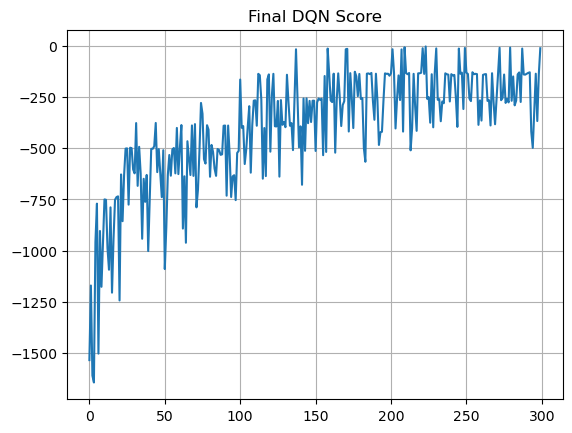

In [11]:
env = gym.make('Pendulum-v1')
state_size = env.observation_space.shape[0]
action_size = 50

agent = Agent(state_size, action_size)

EPOCHS = 300
custom_score_list = []
score_list = []

for EP in range(EPOCHS):
    state, info = env.reset()
    score = 0
    custom_score = 0
    done = False

    while not done:
        # Convert the state to a tensor and move it to the correct device
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

        # Select an action based on the current state
        action, action_index = agent.select_action(state_tensor)

        # Perform the action in the environment
        next_state, reward, done, truncated, _ = env.step([action])
        
        if done or truncated:
            done = True
        # Store the experience in the replay buffer
        agent.store_experience(state, action_index, reward, next_state, done)
        # Train the agent
        agent.train_agent()

        # Update the state and accumulate the score
        state = next_state
        score += reward

    # Append the score of the EP to the list for plotting
    score_list.append(score)
    custom_score_list.append(custom_score)
    print(f"Epoch {EP + 1}/{EPOCHS}, Score: {score}, Epsilion: {agent.epsilon}")

plt.plot(score_list)
plt.grid(True)
plt.title("Final DQN Score")
plt.show()

In [3]:
def save_model(agent, filename="LEAD.pth"):
    checkpoint = {
        'model_state_dict': agent.model.state_dict(),
        'target_model_state_dict': agent.target_model.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'replay_buffer_experiences': agent.memory.buffer,
        'replay_buffer_priorities': agent.memory.priorities,
        'epsilon': agent.epsilon,
        'beta': agent.beta
    }
    torch.save(checkpoint, filename)
    print("Model saved!")

def load_model(agent, filename="LEAD.pth"):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename, map_location=device)
        agent.model.load_state_dict(checkpoint['model_state_dict'])
        agent.target_model.load_state_dict(checkpoint['target_model_state_dict'])
        agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        agent.memory.buffer = checkpoint['replay_buffer_experiences']
        agent.memory.priorities = checkpoint['replay_buffer_priorities'] 
        agent.epsilon = checkpoint['epsilon']
        agent.beta = checkpoint['beta'] 
    else:
        print("No saved model found.")

In [35]:
save_model(agent)

Model saved!


In [4]:
def evaluate_agent(env, agent, n_episodes=10):
    scores = []

    for _ in range(n_episodes):
        state, _ = env.reset()
        score = 0
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            action, _ = agent.select_action(state_tensor)
            next_state, reward, done, truncated, _ = env.step([action])
            done = done or truncated
            state = next_state
            score += reward

        scores.append(score)

    return scores

In [9]:
env = gym.make('Pendulum-v1')
state_size = env.observation_space.shape[0]
action_size = 50

agent = Agent(state_size, action_size)
load_model(agent)

# Evaluate the agent
scores = evaluate_agent(env, agent, n_episodes=100)
average_score = sum(scores) / len(scores)
print(f"Average Score over 100 episodes: {average_score}")

Average Score over 100 episodes: -181.49059439892503


In [13]:
env = gym.make('Pendulum-v1', render_mode='human')
state_size = env.observation_space.shape[0]
action_size = 50

agent = Agent(state_size, action_size)
load_model(agent)

# Evaluate the agent
evaluate_agent(env, agent, n_episodes=1)
env.close()